# Non-standard calculations

In this chapter we will consider some non-standard calculations. Some can be useful but need care for practical considerations (*i.e.* transient X-ray spectroscopy), and some are more illustrations of alternative (but not recommended) ways of modelling spectra. Be careful before directly adopting these approaches for some practical problem.

*Loading modules and routines:*

In [3]:
import copy
import adcc
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

au2ev = 27.211386

## Transient X-ray absorption spectroscopy

An increasingly large field of study is to use a pump-probe protocol, where some chemical reaction is initiated by some pump (typically a laser), and the dynamics are then probed using some X-ray spectroscopy. The modeling of such process is quite new, and we will here present some protocols of how such processes can be considered.

### Valence-excited reference state

By using an excited state as the references state, the X-ray absorption spectra can be considered in a manner similar to XES:
1. Perform a ground state calculation
2. Use the result as initial guess for a second calculation, where the occupations are changed to emulate that of the desired (valence) excited state
3. Perform a wave function optimization with above configuration, using a constraint such as MOM to avoid a collapse to the ground state
4. Calculate the X-ray absorption spectra of this reference state

When considering (singlet) valence-excitations of a closed-shell molecule, two different reference state spin-muliticiplicity configurations are possible:
- Low-spin open-shell reference (LSOR), which moves an electron within the same multiplicity
- High-spin open-shell reference (HSOR), which flips the spin of the moved electron, and thus forms a triplet reference state (when considering singlet excitations of a closed-shell system)

Note that the LSOR wave function will be heavily spin contaminated, as seen below. This has been claimed to lead to minimal errors, but care should be taken. Further note that converging to a reference state which represents the actual valence excitation is non-trivial, and may indeed be all but impossible. As such, this two-step approach is useful, but has some issues. Finally, if using correlated methods, there are some concerns that the [observed](https://doi.org/10.1063%2F4.0000070) relative energies are off from experimental values, which could relate to issues with using a [non-Aufbau](https://doi.org/10.1039/D2CP00584K) reference state.

As an example we consider the first valence-excited state of water:

```{note}
pyscf version - to be changed
```

```python
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

print('GS:')
scf_gs = scf.UHF(mol)
scf_gs.kernel()

print('LSOR:')
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[0][5] = 1.0
scf_lsor = scf.UHF(mol)
scf.addons.mom_occ(scf_lsor, mo0, occ0)
scf_lsor.kernel()

print('HSOR:')
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[1][5] = 1.0
scf_hsor = scf.UHF(mol)
scf.addons.mom_occ(scf_hsor, mo0, occ0)
scf_hsor.kernel()
```

As can be seen, the $\langle S^2 \rangle$ of the LSOR reference is close to 1, and thus represents an almost perfect mix of a singlet and triplet.

Calculating the valence-excitation energies and comparing it to energy differences obtained from the different reference states:

```python
adc_gs = adcc.adc2(scf_gs, n_states=5)
adc_xas = adcc.cvs_adc2(scf_gs, n_states=5, core_orbitals=1)
adc_lsor = adcc.cvs_adc2(scf_lsor, n_states=5, core_orbitals=1)
adc_hsor = adcc.cvs_adc2(scf_hsor, n_states=5, core_orbitals=1)
print(adc_gs.describe())
print(27.2114 * (adc_gs.ground_state.energy() - adc_lsor.ground_state.energy()))
print(27.2114 * (adc_gs.ground_state.energy() - adc_hsor.ground_state.energy()))
```

The first allowed transition energy is relatively close to the $\Delta$MP2 results (as we use the MP2 energies), in particular for the LSOR. Resulting spectra can now be plotted as:

```python
plt.figure(figsize=(6,3))
adc_xas.plot_spectrum(label="GS")
adc_lsor.plot_spectrum(label="LSOR")
adc_hsor.plot_spectrum(label="HSOR")
plt.legend()
plt.show()
```

We see the occurance of a lower-energy feature, representing the 1s to SOMO transition, as well as an upward shift of remaining features.

### Coupling valence- and core-excited eigenstates

- To be added


(sec:xray_cvs_vs_full)=
## Impact of channel restriction for TDDFT

The influence of channel-restriction/CVS schemes for TDDFT can be considered for smaller systems by diagonalizing the full-space and CVS-space matrices, thus constructing the total global spectrum. This will not be possible for larger systems/basis sets, or for correlated method, where other [CVS relaxation schemes](https://doi.org/10.1063/5.0013538) have been used instead.

For a discussion of the underlying theory, see related sections, and here we primarily note that we will construct and resolve the RPA, obtaining transition energies as poles by solving the eigenvalue problem:
$$
E^{[2]}X = {\lambda} S^{[2]}X 
$$

where

$$
{\lambda} =\begin{pmatrix}
\lambda & 0\\
0 & -\lambda
\end{pmatrix}
$$

By rewriting the linear response equation, we obtain the oscillator strength as:

$$
(T^{\mu})^{2} = \sum_{\beta=x,y,z}{\mu_{\beta}^{[1]}}^\dagger X_n X_n^{\dagger}\mu_{\beta}^{[1]}\\
f_{osc}^{if} = \frac{2}{3}\cdot \omega_{if}\cdot(T^{\mu})^2
$$

This will now be done for water, where the ground state is calculated as:

In [4]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

basis = "6-31G"
vlx_mol = vlx.Molecule.read_molecule_string(water_mol_str)
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(vlx_mol, vlx_bas)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
         

{'S': array([[ 1.        ,  0.23368986,  0.16727976,  0.03446908,  0.06872281,
          0.03446908,  0.06872281,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.23368986,  1.        ,  0.76364081,  0.24635401,  0.37904536,
          0.24635401,  0.37904536,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.16727976,  0.76364081,  1.        ,  0.4254384 ,  0.68219684,
          0.4254384 ,  0.68219684,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.03446908,  0.24635401,  0.4254384 ,  1.        ,  0.65829197,
          0.05097439,  0.22309719,  0.        ,  0.        , -0.1749796 ,
         -0.35743592, -0.22558965, -0.46081854],
        [ 0.06872281,  0.37904536,  0.68219684,  0.65829197,  1.        ,
          0.22309719,  0.51449213,  0.        ,  0.        , -0.09059884,
         -0.29517246, -0.1168031 , -0.38054637],
        [ 

### Full-space results

For the full-space results, we construct the Hessian and property gradients:

In [5]:
lrs = vlx.LinearResponseEigenSolver()
lrs.update_settings(scf_settings, method_settings)
rsp_drv = vlx.LinearResponseSolver()
rsp_drv.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lrs.get_e2(vlx_mol, vlx_bas, scf_results)

# Property gradients for dipole operator
V1_x = rsp_drv.get_prop_grad("electric dipole", "x", vlx_mol, vlx_bas, scf_results)[0]
V1_y = rsp_drv.get_prop_grad("electric dipole", "y", vlx_mol, vlx_bas, scf_results)[0]
V1_z = rsp_drv.get_prop_grad("electric dipole", "z", vlx_mol, vlx_bas, scf_results)[0]

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2 * c)
S2[c : 2 * c, c : 2 * c] *= -1

* Info * Molecular grid with 35950 points generated in 0.01 sec.                                                          
                                                                                                                          
* Info * Processing Fock builds... (batch size: 160)                                                                      
* Info *   batch 1/1                                                                                                      


Calculating the excitation energies and oscillator strengths:

In [6]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2)  # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    Xf = X[:, j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x) ** 2 + np.dot(Xf, V1_y) ** 2 + np.dot(Xf, V1_z) ** 2
    fosc.append(tm * 2.0 / 3.0 * eigs[j])

### CVS-space results

The dimensions of the CVS-space:

In [7]:
# Number of virtuals
nocc = vlx_mol.number_of_alpha_electrons()
nvirt = vlx.MolecularBasis.get_dimensions_of_basis(vlx_bas, vlx_mol) - nocc
n = nocc * nvirt

# CVS space
res_mo = 1
res_indx = 0
c = res_mo * nvirt

Hessian and property gradients:

In [8]:
## Construct CVS objects

# Define starting index for deexcitation
c_int_deex = n + res_indx

# CVS Hessian
E2_cvs = np.zeros((2 * c, 2 * c))
E2_cvs[0:c, 0:c] = E2[res_indx:c, res_indx:c]
E2_cvs[0:c, c : 2 * c] = E2[res_indx:c, c_int_deex : c_int_deex + c]
E2_cvs[c : 2 * c, 0:c] = E2[c_int_deex : c_int_deex + c, res_indx:c]
E2_cvs[c : 2 * c, c : 2 * c] = E2[
    c_int_deex : c_int_deex + c, c_int_deex : c_int_deex + c
]

# CVS overlap matrix
S2_cvs = np.identity(2 * c)
S2_cvs[c : 2 * c, c : 2 * c] *= -1

# CVS property gradients
V1_cvs_x = np.zeros(2 * c)
V1_cvs_x[0:c] = V1_x[res_indx:c]
V1_cvs_x[c : 2 * c] = V1_x[c_int_deex : c_int_deex + c]
V1_cvs_y = np.zeros(2 * c)
V1_cvs_y[0:c] = V1_y[res_indx:c]
V1_cvs_y[c : 2 * c] = V1_y[c_int_deex : c_int_deex + c]
V1_cvs_z = np.zeros(2 * c)
V1_cvs_z[0:c] = V1_z[res_indx:c]
V1_cvs_z[c : 2 * c] = V1_z[c_int_deex : c_int_deex + c]

Calculating energies and intensities:

In [9]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2_cvs)  # for clarity - is identical
M = np.matmul(Sinv, E2_cvs)
eigs_cvs, X_cvs = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs_cvs)
eigs_cvs = np.array(eigs_cvs)[idx]
X_cvs = np.array(X_cvs)[:, idx]

# Compute oscillator strengths
fosc_cvs = []
for i in range(int(len(eigs_cvs) / 2)):
    j = i + int(len(eigs_cvs) / 2)  # focus on excitations
    Xf_cvs = X_cvs[:, j]
    Xf_cvs = Xf_cvs / np.sqrt(np.matmul(Xf_cvs.T, np.matmul(S2_cvs, Xf_cvs)))
    tm_cvs = (
        np.dot(Xf_cvs, V1_cvs_x) ** 2
        + np.dot(Xf_cvs, V1_cvs_y) ** 2
        + np.dot(Xf_cvs, V1_cvs_z) ** 2
    )
    fosc_cvs.append(tm_cvs * 2.0 / 3.0 * eigs_cvs[j])

### Comparison

Comparing the obtained spectra:

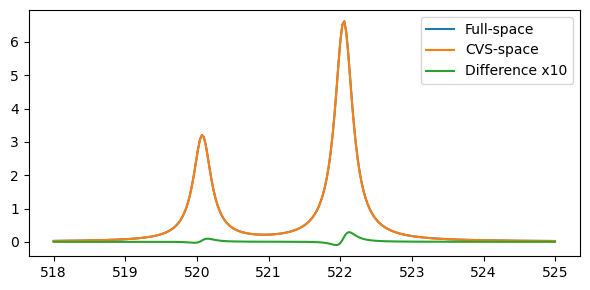

In [10]:
plt.figure(figsize=(6,3))
x, y = eigs[int(len(eigs) / 2) :], fosc
x1, y1 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x1 * au2ev, y1)
x, y = eigs_cvs[int(len(eigs_cvs) / 2) :], fosc_cvs
x2, y2 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x2 * au2ev, y2)
plt.plot(x2 * au2ev, 10*(y1 - y2))
plt.legend(("Full-space", "CVS-space", "Difference x10"))
plt.tight_layout()
plt.show()

We note a small difference between the two approaches. This difference has some dependence on the basis set, but will continue to be small for the *K*-edge.

```{note}
To be added: comparison to CVS functionalities in `VeloxChem` (currently unavailable).
```

(sec:xray_ie_diffuse)=
## Ionization energies from XAS

Can model the ionization energy by targetting excitations to extremely diffuse molecular orbital. Here: consider both spectrum and IE of water, at a CVS-ADC(2)-x/6-31G[+diffuse] level of theory.

- To be added

## Ionization energies from XES

Can model the ionization energy by targetting decays from an extremely diffuse molecular orbital, with a core-electron already moved to it. The need of preparing this state makes the approach rather useless, but it can still provide insight into relaxation effects of XES. Here: consider the IE of water, at a CVS-ADC(2)/6-31G[+diffuse] level of theory.

- To be added

## XES considered in reverse

Instead of modeling XES by looking at the (negative) eigenstates of a core-hole reference state, it is possible to use a valence-hole reference state, and then consider core-excitations into this hole. This thus models the XES process more from the point of view of XAS, *i.e.* in reverse. However, this approach presupposes:

1. That a single-particle picture works quite well, and that specific valence-hole will yield reasonable representations of the valence-hole left following decay into a core-hole
2. That the valence-hole can be converged well, and that the different (non-orthogonal) reference states from each calculation are sufficiently consistent with each other

Furthermore, the calculation is made more tedious, as

3. It requires one explicit calculation per state

As such, this approach is by not suggested for practical calculations, but it does illustrate the ease of which such exotic calculations can be run, as well as teach us something about the relaxation of core-transitions.

Considering the X-ray emission spectra of water, we create valence-holes in the four frontier valence MOs and construct a spectrum from this:

```{note}
pyscf version - to be changed
```

```python
# Containers for resulting energies and intensities
xes_rev_E = []
xes_rev_f = []

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbital coefficients
mo0 = copy.deepcopy(scf_res.mo_coeff)

# Reference calculation from core-hole
occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()
adc_xes = adcc.adc2(scf_ion, n_states=4)
xes_E = -au2ev * adc_xes.excitation_energy
xes_f = adc_xes.oscillator_strength

for i in range(4):
    occ0 = copy.deepcopy(scf_res.mo_occ)
    occ0[0][4 - i] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Perform ADC calculation of first four states
    adc_xes = adcc.cvs_adc2(scf_ion, n_states=1, core_orbitals=1)
    xes_rev_E.append(au2ev * adc_xes.excitation_energy)
    xes_rev_f.append(adc_xes.oscillator_strength)
```

Comparing the two different spectra:

```python
plt.figure(figsize=(6, 3))
xi, yi = lorentzian(xes_E, xes_f, 518, 534, 0.01, 0.5)
plt.plot(xi, yi)
xi, yi = lorentzian(xes_rev_E, xes_rev_f, 518, 534, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("From core-hole", "From valence-hole"))
plt.tight_layout()
plt.show()
```


```{figure} ../../img/xray/xes_reverse.svg
---
name: xes_reverse
scale: 8%
---
```